<a href="https://colab.research.google.com/github/al34n1x/DataScience/blob/master/99.Machine_Learning/11_decision_trees_and_random_forests_Bank_DF_Var_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Decision Trees y Random Forests

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




En este notebook vamos a aprender a utilizar Árboles de Decisión en Scikit-learn.
Como veremos, los árboles de decisión son extremadamente intiutivos. En el fondo codifican una serie de decisiones de la misma manera que lo haría una sentencia condicional *if-else*. La diferencia es que, en lugar de programar estas decisiones manualmente, el árbol aprende a generarlas automáticamente en función de los datos de entrenamiento.
Por ejemplo, si queremos utilizar una guía para identificar animales, podríamos preguntar las siguientes preguntas:

- Este animal, mide más de un metro de longitud?
    + *Más de 1m long*. ¿Tiene cuernos?
        - *Sí*: ¿Miden sus cuernos más de 10cm de longitud?
        - *No*: ¿El animal tiene pelo o escamas?
    + *Menos de 1m *: ¿El animal tiene 2 o 4 patas?
        - *Dos patas*: ¿Tiene alas?
        - *Cuatro patas*: ¿Tiene cola de más de 12 cm de largo?
  
Y así podría seguir... La esencia de un árbol de decisión es ir realizando preguntas que permitan hacer particiones binarias del dataset.

Una de las principales ventajas de los árboles es que necesitan muy poco pre-procesado (p.ej. son invariantes al escalado de las variables) y permiten trabajar con diferentes tipos de variables (contínuas, discretas). 



## Decision Trees: Regresión



Vamos a empezar con un ejemplo de árboles de Regresión. Para ello crearemos un árbol de decisión que intentará ajustar los datos sinténticos que vamos a crear a continuación:

In [3]:
def make_dataset(n_samples=100):
    rnd = np.random.RandomState(42)
    x = np.linspace(-3, 3, n_samples)
    y_no_noise = np.sin(4 * x) + x
    y = y_no_noise + rnd.normal(size=len(x))
    return x, y

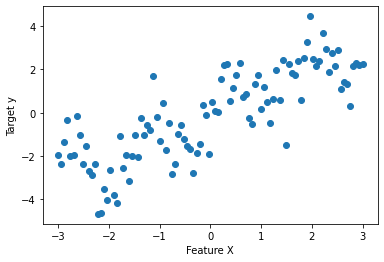

In [4]:
x, y = make_dataset()
X = x.reshape(-1, 1)

plt.xlabel('Feature X')
plt.ylabel('Target y')
plt.scatter(X, y);

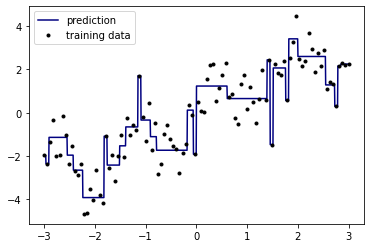

In [5]:
from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor(max_depth=5)
reg.fit(X, y)

X_fit = np.linspace(-3, 3, 1000).reshape((-1, 1))
y_fit_1 = reg.predict(X_fit)

plt.plot(X_fit.ravel(), y_fit_1, color='navy', label="prediction")
plt.plot(X.ravel(), y, '.k', label="training data")
plt.legend(loc="best");



##### Como vemos, el modelo genera zonas con líneas planas muy anchas (bias) y zonas con cambios verticales muy bruscos ajustándose a uno o muy pocos puntos (overfitting).

Esto es uno de los problemas típicos de los árboles que se puede controlar con la profundidad del mismo. 

## Ejercicio

- Probar varios parámetros de profundidad y observar como aumentan el bias y la varianza del modelo.



# Decision Tree: Clasificación

Los problemas de clasificación también se pueden resolver árboles de decisión.


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#Importo el CSV creado previamente

df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/UADE/Diplomatura Ciencia de Datos/Material de Clases/MESES_201402_201404.csv', dtype={"numero_de_cliente": int, "foto_mes": int, "cliente_sucursal": "string"})


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (48) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
df2.head()

,Unnamed: 0,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,tpaquete_premium,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,tcuentas,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ttarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,...,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo,target,target_bin
0,22,5609788,201402,0,0,224,61,237,0.00,9669.42,0.0,0.0,0.0,8,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,2306.92,0.0,0.00,1.17,1214.93,S,0,0.00,S,12,5488.64,...,5930,0,0,0,96162.31,0,0,20140213,5930,-2696.97,0,20010227,0,N,N,3006.9,0,10,87488.34,20220331,NaN,4765.27,5575.36,0,377.24,0,97211.31,0,0,20140227,0,-20743.77,1467.03,19970317,377.24,S,N,3229.2,Continua,0
1,38,5609981,201402,0,0,227,64,196,0.00,4107.16,0.0,0.0,0.0,9,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,1568.13,0.0,0.00,1.17,1061.04,S,0,0.00,S,2,706.14,...,0,0,.,.,10530,.,.,20140227,0,.,.,20010309,.,S,S,0,0,10,15795,20170331,NaN,6505.05,7610.9,0,706.14,0,17550,0,0,20140227,0,-713.7,0,20010308,706.14,S,N,748.8,Continua,0
2,54,5610023,201402,0,0,536,41,91,0.00,2888.84,0.0,0.0,0.0,9,S,N,N,N,N,N,N,N,N,S,S,0.0,0.00,0.0,S,1409.87,0.0,0.00,1.17,748.50,S,2,538.20,S,9,1278.52,...,4055.87,0,936,0,97211.31,0,0,20140227,0,-3054.16,0,20060802,936,S,N,1649.7,0,10,87488.34,20150831,NaN,858.11,1003.98,0,361.64,0,97211.31,0,0,20140227,0,-1881.83,0,20060802,361.64,S,N,93.6,Continua,0
3,70,5610089,201402,0,0,545,0,237,2597.43,0.00,0.0,0.0,0.0,12,S,N,N,N,N,N,N,N,N,S,S,0.0,-928.10,0.0,S,2181.47,0.0,0.00,1.17,823.96,S,0,0.00,S,10,9905.94,...,7571.71,0,7436.74,0,64832.22,0,0,20140206,7571.71,-6105.3,0,20100112,7436.74,S,N,421.2,0,10,87488.34,20180131,NaN,8619.29,9624.23,460.33,6017.28,58.44,97211.31,0,0,20140227,0,-7631.25,0,20100120,6017.28,S,N,1673.1,Continua,0
4,86,5610101,201402,0,0,1217,49,45,0.00,46303.03,0.0,0.0,0.0,11,S,N,N,N,N,N,N,N,N,S,S,0.0,21043.29,0.0,S,38499.54,0.0,114.75,1.17,46223.92,S,9,3836.39,S,9,2755.82,...,5064.64,0,58.38,0,126721.23,0,0,20140227,0,-5076.55,0,20130626,58.38,S,N,2562.3,0,10,142554.47,20210831,NaN,2378.44,2782.77,0,1050.96,0,158401.53,0,0,20140227,0,-18960.01,1514.84,20100809,1050.96,S,N,304.2,Continua,0


In [9]:
# Elimino la primer columna
df2 = df2.loc[:, ~df2.columns.str.contains('^Unnamed')]

In [10]:
df2.describe(include='all')  

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_sucursal,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,tpaquete_premium,tpaquete2,tpaquete3,tpaquete4,tpaquete5,tpaquete6,tpaquete7,tpaquete8,tpaquete9,tcuentas,tcuenta_corriente,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,tcaja_ahorro,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ttarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ttarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ttarjeta_master,...,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_tconsumos,Master_tadelantosefectivo,Master_mpagominimo,Visa_marca_atraso,Visa_cuenta_estado,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_tconsumos,Visa_tadelantosefectivo,Visa_mpagominimo,target,target_bin
count,1.819810e+05,181981.0,181981.0,181981.000000,181981,181981.000000,181981.000000,181981.000000,181981.000000,181981.0,181981.0,181981.0,181981.000000,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981.000000,1.819810e+05,181981.0,181981,1.819810e+05,181981.000000,1.819810e+05,181981.000000,1.819810e+05,181981,181981.000000,181981.000000,181981,181981.000000,181981.000000,181981,...,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,1562.0,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981,181981.000000
unique,NaN,NaN,NaN,NaN,341,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2,1,2,1,2,2,1,2,2,2,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,2,NaN,NaN,2,...,85187,12019,49494,9952,99,1107,819,102,11323,65172,8914,3161,49494,2,2,2124,3,5,241,147,NaN,150145,149670,21877,115848,19761,156,2056,1621,82,13866,119715,16842,5400,115848,2,2,2760,3,NaN
top,NaN,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,S,N,N,N,N,N,N,N,N,S,S,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,S,NaN,NaN,S,...,0,0,.,.,.,0,0,20140227,0,.,0,.,.,S,N,0,0,10,15795,.,NaN,0,0,0,.,0,17550,0,0,20140227,0,.,0,.,.,S,N,0,Continua,NaN
freq,NaN,NaN,NaN,NaN,3779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181981,179146,181981,181322,181981,181889,177457,181981,177890,180599,175936,NaN,NaN,NaN,180569,NaN,NaN,NaN,NaN,NaN,179921,NaN,NaN,170796,NaN,NaN,155838,...,60486,141566,85200,85200,25543,94410,95420,92994,141102,85200,85367,25543,85200,150125,94410,72021,169956,170758,28174,10463,NaN,11021,11034,139253,20625,126736,28274,156861,158755,100809,152933,20625,135589,10463,20625,164031,156861,17884,180609,NaN
mean,2.114644e+07,201402.0,0.0,0.028695,NaN,42.782351,119.048181,141.154399,6605.207343,0.0,0.0,0.0,9.006990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.627804,8.310604e+02,0.0,NaN,1.695211e+04,381.580838,4.178486e+03,1.106531,2.554148e+04,NaN,5.177716,2422.753100,NaN,13.942137,5153.372915,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.004248
std,1.096325e+07,0.0,0.0,0.166949,NaN,17.946860,70.996962,1731.792519,7295.570352,0.0,0.0,0.0,2.182639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5124.011375,1.826044e+04,0.0,NaN,5.266209e+04,8259.779040,5.280153e+04,0.265012,1.047721e+05,NaN,8.086673,7817.827115,NaN,15.006813,7082.207852,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181981 entries, 0 to 181980
Columns: 171 entries, numero_de_cliente to target_bin
dtypes: float64(43), int64(39), object(88), string(1)
memory usage: 237.4+ MB


In [12]:
df2.dtypes

numero_de_cliente                  int64
foto_mes                           int64
marketing_activo_ultimos90dias     int64
cliente_vip                        int64
cliente_sucursal                  string
                                   ...  
Visa_tconsumos                    object
Visa_tadelantosefectivo           object
Visa_mpagominimo                  object
target                            object
target_bin                         int64
Length: 171, dtype: object

In [13]:
X = df2.drop(['target' , 'target_bin'] , axis='columns')
y = df2.target_bin

In [14]:
#Transformo Variables Categoricas
X = pd.get_dummies(X, columns = ['tpaquete2', 'tpaquete4', 'tpaquete6', 'tpaquete7', 'tpaquete9', 'tcuentas', 'tcuenta_corriente', 'tcaja_ahorro', 'ttarjeta_debito', 'ttarjeta_visa', 'ttarjeta_master'])

In [15]:
X.dtypes

numero_de_cliente                  int64
foto_mes                           int64
marketing_activo_ultimos90dias     int64
cliente_vip                        int64
cliente_sucursal                  string
                                   ...  
ttarjeta_debito_S                  uint8
ttarjeta_visa_N                    uint8
ttarjeta_visa_S                    uint8
ttarjeta_master_N                  uint8
ttarjeta_master_S                  uint8
Length: 180, dtype: object

In [16]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64', 'uint8']
X = X.select_dtypes(include=numerics)
#one_hot_encoding
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
X = X.fillna(0)

In [17]:
X.describe()

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mplazo_fijo_dolares,mplazo_fijo_pesos,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,mtitulos,mbonos_gobierno,mmonedas_extranjeras,minversiones_otras,mplan_sueldo,...,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,ccallcenter_transacciones,chomebanking_transacciones,cautoservicio_transacciones,ccajeros_propio_transacciones,mcajeros_propio,ccajeros_ajenos_transacciones,mcajeros_ajenos,Master_Finiciomora,Visa_Finiciomora,tpaquete2_N,tpaquete2_S,tpaquete4_N,tpaquete4_S,tpaquete6_N,tpaquete6_S,tpaquete7_N,tpaquete7_S,tpaquete9_N,tpaquete9_S,tcuentas_N,tcuentas_S,tcuenta_corriente_N,tcuenta_corriente_S,tcaja_ahorro_N,tcaja_ahorro_S,ttarjeta_debito_N,ttarjeta_debito_S,ttarjeta_visa_N,ttarjeta_visa_S,ttarjeta_master_N,ttarjeta_master_S
count,1.819810e+05,181981.0,181981.0,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.0,181981.0,181981.0,181981.000000,181981.000000,1.819810e+05,181981.0,1.819810e+05,181981.000000,1.819810e+05,181981.000000,1.819810e+05,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,1.819810e+05,1.819810e+05,1.819810e+05,1.819810e+05,1.819810e+05,181981.0,181981.0,181981.0,181981.0,...,181981.000000,181981.000000,1.819810e+05,181981.000000,1.819810e+05,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.0,181981.0,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.00000,181981.00000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000,181981.000000
mean,2.114644e+07,201402.0,0.0,0.028695,42.782351,119.048181,141.154399,6605.207343,0.0,0.0,0.0,9.006990,60.627804,8.310604e+02,0.0,1.695211e+04,381.580838,4.178486e+03,1.106531,2.554148e+04,5.177716,2422.753100,13.942137,5153.372915,3.888356,1656.629983,0.798045,13893.997331,0.029877,2189.701911,0.036449,1.732227e+04,1.803649e+03,1.919651e+03,5.007695e+01,9.834504e+03,0.0,0.0,0.0,0.0,...,3879.035183,0.380606,3.366807e+03,0.372303,2.370965e+03,0.010655,110.521576,0.010127,96.910834,0.661613,0.0,0.0,1.436754,2471.631044,1.154807,1411.180126,0.015276,0.017167,0.984421,0.015579,0.996379,0.003621,0.999494,0.000506,0.975140,0.024860,0.97752,0.02248,0.007594,0.992406,0.033218,0.966782,0.007759,0.992241,0.011320,0.988680,0.061462,0.938538,0.143658,0.856342
std,1.096325e+07,0.0,0.0,0.166949,17.946860,70.996962,1731.792519,7295.570352,0.0,0.0,0.0,2.182639,5124.011375,1.826044e+04,0.0,5.266209e+04,8259.779040,5.280153e+04,0.265012,1.047721e+05,8.086673,7817.827115,15.006813,7082.207852,7.470251,4152.271154,1.798865,26386.779007,0.173762,15834.866886,0.199257,1.689042e+05,5.044693e+04,5.621293e+04,3.776229e+03,2.103115e+05,0.0,0.0,0.0,0.0,...,6319.707515,2.334465,3.968315e+04,2.267652,3.177423e+04,0.138054,3377.116121,0.229445,3597.863225,2.156619,0.0,0.0,2.570564,5112.239770,2.413118,3252.314786,0.174125,0.184496,0.123838,0.123838,0.060068,0.06006

In [18]:
#Creo variables
X['mcuenta_corriente_all'] = X['mcuenta_corriente_Paquete'] + X['mcuenta_corriente_Nopaquete']
X['mcaja_ahorro_all'] = X['mcaja_ahorro_Paquete'] + X['mcaja_ahorro_Nopaquete']
X['mcaja_ahorro_CC'] = X['mcaja_ahorro_all'] + X['mcuenta_corriente_all']
X['mtarjeta_all_consumo'] = X['mtarjeta_visa_consumo'] + X['mtarjeta_master_consumo']
X['ctarjeta_all_transacciones'] = X['ctarjeta_visa_transacciones'] + X['ctarjeta_master_transacciones']
#X['ctarjeta_all_transacciones'] = X['ctarjeta_visa_transacciones'] + X['ctarjeta_master_transacciones']
X.head()

,numero_de_cliente,foto_mes,marketing_activo_ultimos90dias,cliente_vip,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,marketing_coss_selling,mcuenta_corriente_Nopaquete,mcuenta_corriente_Paquete,mcuenta_corriente_dolares,mcaja_ahorro_Paquete,mcaja_ahorro_Nopaquete,mcaja_ahorro_dolares,mdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mplazo_fijo_dolares,mplazo_fijo_pesos,mfondos_comunes_inversion_pesos,mfondos_comunes_inversion_dolare,mtitulos,mbonos_gobierno,mmonedas_extranjeras,minversiones_otras,mplan_sueldo,...,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,ccallcenter_transacciones,chomebanking_transacciones,cautoservicio_transacciones,ccajeros_propio_transacciones,mcajeros_propio,ccajeros_ajenos_transacciones,mcajeros_ajenos,Master_Finiciomora,Visa_Finiciomora,tpaquete2_N,tpaquete2_S,tpaquete4_N,tpaquete4_S,tpaquete6_N,tpaquete6_S,tpaquete7_N,tpaquete7_S,tpaquete9_N,tpaquete9_S,tcuentas_N,tcuentas_S,tcuenta_corriente_N,tcuenta_corriente_S,tcaja_ahorro_N,tcaja_ahorro_S,ttarjeta_debito_N,ttarjeta_debito_S,ttarjeta_visa_N,ttarjeta_visa_S,ttarjeta_master_N,ttarjeta_master_S,mcuenta_corriente_all,mcaja_ahorro_all,mcaja_ahorro_CC,mtarjeta_all_consumo,ctarjeta_all_transacciones
0,5609788,201402,0,0,61,237,0.00,9669.42,0.0,0.0,0.0,8,0.0,0.00,0.0,2306.92,0.0,0.00,1.17,1214.93,0,0.00,12,5488.64,5,5844.80,0,0.00,0,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0,0,0.0,...,0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0.00,2306.92,2306.92,11333.44,17
1,5609981,201402,0,0,64,196,0.00,4107.16,0.0,0.0,0.0,9,0.0,0.00,0.0,1568.13,0.0,0.00,1.17,1061.04,0,0.00,2,706.14,0,0.00,0,0.00,0,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0,0,0.0,...,0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0.00,1568.13,1568.13,706.14,2
2,5610023,201402,0,0,41,91,0.00,2888.84,0.0,0.0,0.0,9,0.0,0.00,0.0,1409.87,0.0,0.00,1.17,748.50,2,538.20,9,1278.52,11,4017.37,0,0.00,0,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0,0,0.0,...,0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0.00,1409.87,1409.87,5295.89,20
3,5610089,201402,0,0,0,237,2597.43,0.00,0.0,0.0,0.0,12,0.0,-928.10,0.0,2181.47,0.0,0.00,1.17,823.96,0,0.00,10,9905.94,8,7436.74,0,0.00,0,0.0,0,0.00,0.0,0.0,0.0,0.0,0,0,0,0.0,...,0,0.0,0,0.0,0,0,0,0,0.0,0,0.0,0.0,0.0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,-928.10,2181.47,1253.37,17342.68,18
4,5610101,201402,0,0,49,45,0.00,46303.03,0.0,0.0,0.0,11,0.0,21043.29,0.0,38499.54,0.0,114.75,1.17,46223.92,9,3836.39,9,2755.82,2,4939.03,2,116496.24,0,0.0,0,716743.02,0.0,0.0,0.0,0.0,0,0,0,0.0,...,0,0.0,0,0.0,0,0,0,0,0.0,3,5850.0,0.0,0.0,1,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,21043.29,38499.54,59542.83,7694.85,11


In [19]:
s = df2.target_bin
counts = s.value_counts()
percent = s.value_counts(normalize=True)
percent100 = s.value_counts(normalize=True).mul(100).round(2).astype(str) + '%'
pd.DataFrame({'counts': counts, 'per': percent, 'per100': percent100})

,counts,per,per100
0,181208,0.995752,99.58%
1,773,0.004248,0.42%


In [20]:
#Entreno un Arbol de Decición
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
# Train model
#clf = DecisionTreeClassifier().fit(X_train, y_train)
#clf = DecisionTreeClassifier(max_depth=5).fit(X_train, y_train)
clf = DecisionTreeClassifier(max_depth=5, class_weight='balanced').fit(X_train, y_train)
 
# Predict on training set and test set
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

In [21]:
# Accuracy 
from sklearn.metrics import accuracy_score
print('Accuracy train:',accuracy_score(y_train, y_train_pred))
print('Accuracy test:',accuracy_score(y_test, y_test_pred))

Accuracy train: 0.8815254423563029
Accuracy test: 0.8792421311763672


In [22]:
# veo la matriz de confusión en train
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, y_train_pred)

array([[119826,  16091],
       [    79,    489]])

In [23]:
# veo la matriz de confusión en test
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_test_pred)

array([[39836,  5455],
       [   39,   166]])

In [24]:
#Ahora puedo obtener Recall y Precision
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
print('Accuracy')
print('Train:',accuracy_score(y_train, y_train_pred))
print('Test:',accuracy_score(y_test, y_test_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_train, y_train_pred))
print('Test:',recall_score(y_test, y_test_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_train, y_train_pred))
print('Test:',precision_score(y_test, y_test_pred))


Accuracy
Train: 0.8815254423563029
Test: 0.8792421311763672
 
Recall
Train: 0.8609154929577465
Test: 0.8097560975609757
 
Precision
Train: 0.029493365500603136
Test: 0.029532111723892546


In [25]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_test_pred)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.02


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.02')

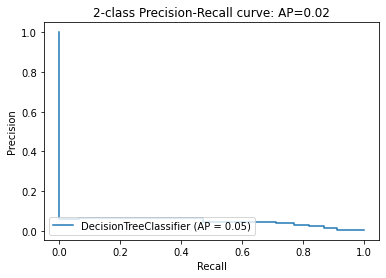

In [26]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf, X_test, y_test)
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))


************************How to plot a ROC Curve in Python*************************
roc_auc_score for DecisionTree:  0.8848964770365728
roc_auc_score for DecisionTree_5:  0.782320829368458
roc_auc_score for Logistic Regression:  0.8693669285503878


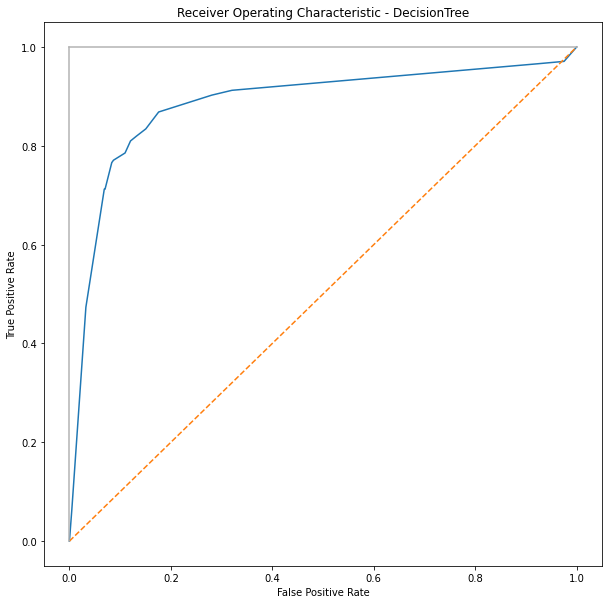

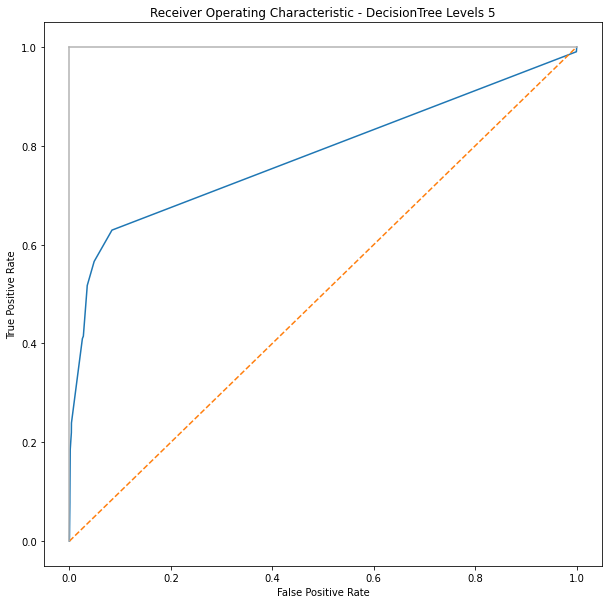

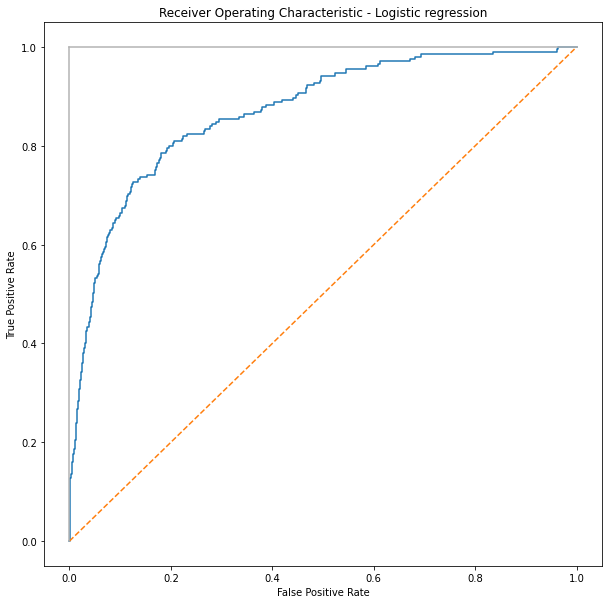

In [27]:
    print()
    print(format('How to plot a ROC Curve in Python','*^82'))

    import warnings
    warnings.filterwarnings("ignore")

    # load libraries
    from sklearn.datasets import make_classification
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt

    # Create feature matrix and target vector
    #X, y = make_classification(n_samples=10000, n_features=100, n_classes=2)

    # Split into training and test sets
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Create classifier
    clf1 = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
    clf2 = DecisionTreeClassifier(max_depth=5)
    clf3 = LogisticRegression()

    # Train model
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)

    # Get predicted probabilities
    y_score1 = clf1.predict_proba(X_test)[:,1]
    y_score2 = clf2.predict_proba(X_test)[:,1]
    y_score3 = clf3.predict_proba(X_test)[:,1]

    # Plot Receiving Operating Characteristic Curve
    # Create true and false positive rates
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
    false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)
    print('roc_auc_score for DecisionTree: ', roc_auc_score(y_test, y_score1))
    print('roc_auc_score for DecisionTree_5: ', roc_auc_score(y_test, y_score2))
    print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score3))

    # Plot ROC curves
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree Levels 5')
    plt.plot(false_positive_rate2, true_positive_rate2)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Logistic regression')
    plt.plot(false_positive_rate3, true_positive_rate3)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

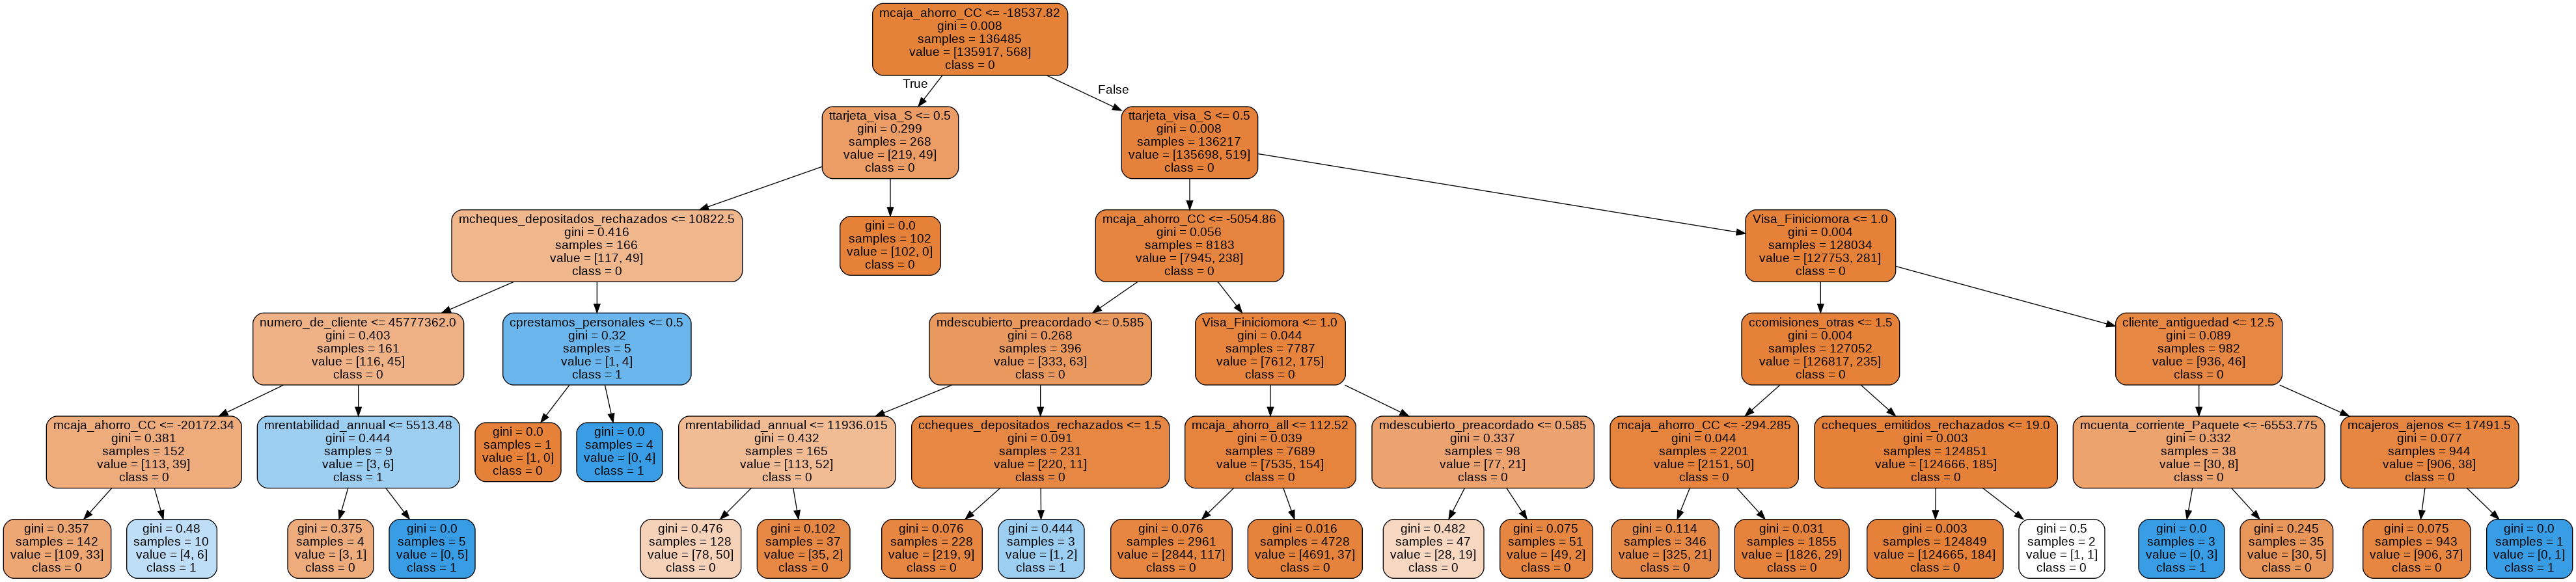

In [28]:
## import dependencies
from sklearn import tree #For our Decision Tree
import pandas as pd # For our DataFrame
import pydotplus # To create our Decision Tree Graph
from IPython.display import Image  # To Display a image of our graph


# The decision tree classifier.
clf2 = tree.DecisionTreeClassifier(max_depth=5)
#clf2 = tree.DecisionTreeClassifier()
# Training the Decision Tree
clf_train = clf2.fit(X_train, y_train)


# Export/Print a decision tree in DOT format.
#print(tree.export_graphviz(clf_train, None))

#Create Dot Data
dot_data = tree.export_graphviz(clf_train, out_file=None, feature_names=list(X_train.columns.values), 
                                class_names=['0', '1'], rounded=True, filled=True) #Gini decides which attribute/feature should be placed at the root node, which features will act as internal nodes or leaf nodes
#Create Graph from DOT data
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())

In [29]:
#Entreno un Arbol de Decición con Cross Validation
from sklearn.model_selection import cross_val_score

clf = DecisionTreeClassifier(random_state=0)

cross_val_score(clf, X, y, cv=10)

array([0.99373592, 0.98071217, 0.99120783, 0.98642708, 0.99109792,
       0.99208704, 0.98944939, 0.65589625, 0.9046049 , 0.01197934])

In [30]:
# Veo los parametros
clf.predict

<bound method BaseDecisionTree.predict of DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')>



 ## Ejercicio

Entrenar el modelo árboles más profundos.

In [31]:
# Respuesta aqui



# Random Forests



Random Forests son ensamblajes de muchos árboles entrenados con diferentes subconjuntos de datos y diferentes subconjuntos de variables del dataset de entrenamiento. 
Esto permite que los árboles del bosque sean diferentes entre ellos. De hecho, cada árbol se especializa en un aspecto diferente del dataset (sobreajusta al subconjunto de datos con los que se ha entrenado ese árbol), pero como la predicción es un promedio de las predicciones de todos los árboles, al final el bosque es capaz de reducir la varianza (overfitting).



## Seleccionando los parámetros de un bosque utilizando Cross-Validation

In [32]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf = RandomForestClassifier(n_estimators=50) #200
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              ran

In [33]:
clf_grid.score(X_train, y_train)

0.9956771806425615

In [34]:
# Predict on training set and test set
y_train_pred = clf_grid.predict(X_train)
y_test_pred = clf_grid.predict(X_test)

In [35]:
print('Accuracy')
print('Train:',accuracy_score(y_train, y_train_pred))
print('Test:',accuracy_score(y_test, y_test_pred))
print(' ')
print('Recall')
print('Train:',recall_score(y_train, y_train_pred))
print('Test:',recall_score(y_test, y_test_pred))
print(' ')
print('Precision')
print('Train:',precision_score(y_train, y_train_pred))
print('Test:',precision_score(y_test, y_test_pred))

Accuracy
Train: 0.9956771806425615
Test: 0.9959776683664499
 
Recall
Train: 0.0
Test: 0.0
 
Precision
Train: 0.0
Test: 0.0


In [36]:
clf_grid.score(X_test, y_test)

0.9959776683664499

In [37]:
clf_grid.best_params_

{'max_depth': 5, 'max_features': 'sqrt'}



## Gradient Boosting



Otro método de ensemble es *Boosting*. Aquí, en lugar de construir 200 estimadores en paralelo (como hacíamos en el bosque anterior), construimos una cadena de 200 estimadores que iterativamente van refinando los resultados del estimador anterior. La idea de boosting es que, utilizar modelos muy simples y rápidos secuencialmente nos permite obtener un error menor que el que pueden obtener los distintos estimadores individualmente.

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
clf = GradientBoostingClassifier(n_estimators=50)
clf.fit(X_train, y_train)

print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9959262922665494
0.9955820291893793


In [39]:
# Predict on training set and test set
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba = clf.predict_proba(X_test)[:,1]

In [40]:
# Ganancia
# TP = 4900
# FP = -100

In [41]:
# Creo Tabla con Clase Real, Clase Predicha y Probabilidad Asociada
df_pred = pd.DataFrame({"y_test": y_test, "y_test_pred": y_test_pred,"prob_a": y_test_proba} )
df_pred.head()

,y_test,y_test_pred,prob_a
77839,0,0,0.001034
108704,1,0,0.020522
46621,0,0,0.003595
4050,0,0,0.000886
80408,0,0,0.000822


In [42]:
# Calculo ganancia
df_pred['profit'] = df_pred['y_test_pred']*(-100)+df_pred['y_test_pred']*df_pred['y_test']*5000
df_pred.head()

,y_test,y_test_pred,prob_a,profit
77839,0,0,0.001034,0
108704,1,0,0.020522,0
46621,0,0,0.003595,0
4050,0,0,0.000886,0
80408,0,0,0.000822,0


In [43]:
# Sumarizaciones
print('Max:', df_pred.profit.max())
print('Min:', df_pred.profit.min())
print('Total:', df_pred.profit.sum())

Max: 4900
Min: -100
Total: 51000


In [44]:
# Ordeno por probabilidad de clase
df_rank = df_pred.sort_values(by=['prob_a'], ascending=False)
df_rank.head()

,y_test,y_test_pred,prob_a,profit
811,0,1,0.986689,-100
112862,0,1,0.958138,-100
53672,0,1,0.816516,-100
83302,0,1,0.798740,-100
179982,1,1,0.777386,4900


In [45]:
# Creo columna de Ganancia Acum
df_rank['cum_profit'] = df_rank.profit.cumsum()
df_rank.head()

,y_test,y_test_pred,prob_a,profit,cum_profit
811,0,1,0.986689,-100,-100
112862,0,1,0.958138,-100,-200
53672,0,1,0.816516,-100,-300
83302,0,1,0.798740,-100,-400
179982,1,1,0.777386,4900,4500


In [46]:
# Sumarizaciones
print('Max:', df_rank.cum_profit.max())
print('Total:', df_pred.profit.sum())

Max: 51200
Total: 51000


In [47]:
df_rank.head(30)

,y_test,y_test_pred,prob_a,profit,cum_profit
811,0,1,0.986689,-100,-100
112862,0,1,0.958138,-100,-200
53672,0,1,0.816516,-100,-300
83302,0,1,0.798740,-100,-400
179982,1,1,0.777386,4900,4500
173558,0,1,0.751691,-100,4400
163793,0,1,0.736149,-100,4300
55377,0,1,0.688518,-100,4200
131501,1,1,0.677219,4900,9100
180091,1,1,0.631731,4900,14000



************************How to plot a ROC Curve in Python*************************
roc_auc_score for DecisionTree - MaxDepth = 5, Balanced:  0.8576407040814714
roc_auc_score for GradientBoostingClassifier:  0.9051020232194309
roc_auc_score for Random Forest:  0.7844385120182281
roc_auc_score for Logistic Regression:  0.8799108182442968


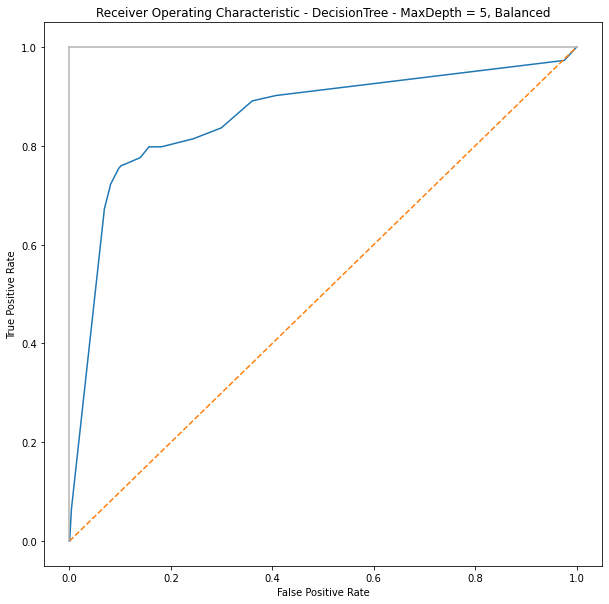

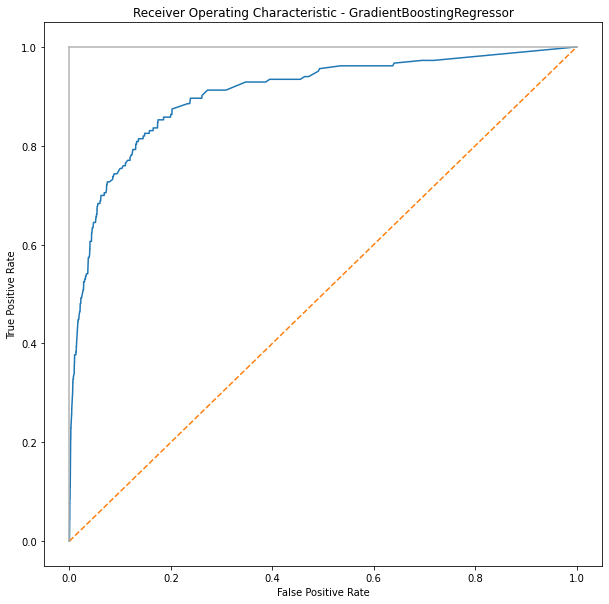

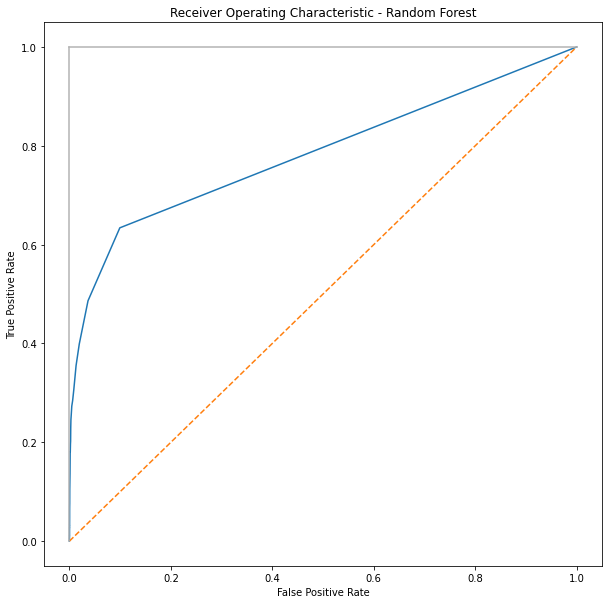

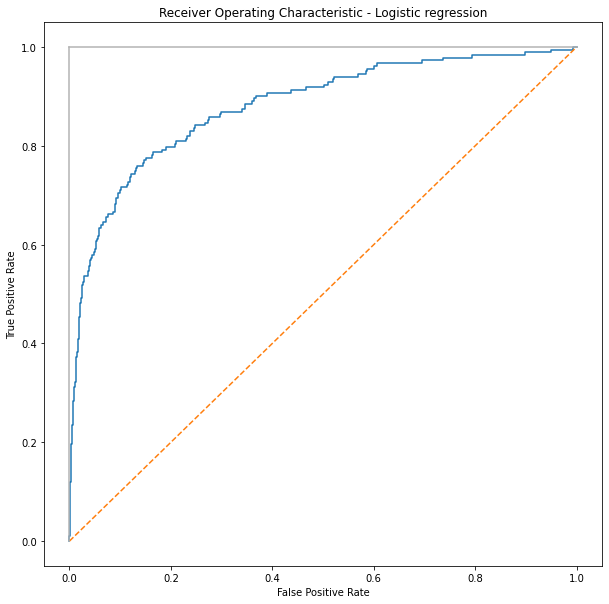

In [48]:
    print()
    print(format('How to plot a ROC Curve in Python','*^82'))

    import warnings
    warnings.filterwarnings("ignore")

    # load libraries
    from sklearn.datasets import make_classification
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.ensemble import GradientBoostingClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import roc_curve, roc_auc_score
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt

    # Create feature matrix and target vector
    #X, y = make_classification(n_samples=10000, n_features=100, n_classes=2)

    # Split into training and test sets
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    # Create classifier
    clf1 = DecisionTreeClassifier(max_depth=5, class_weight='balanced')
    clf2 = GradientBoostingClassifier(n_estimators=50)
    clf3 = RandomForestClassifier(n_estimators=50)
    clf4 = LogisticRegression()

    # Train model
    clf1.fit(X_train, y_train)
    clf2.fit(X_train, y_train)
    clf3.fit(X_train, y_train)
    clf4.fit(X_train, y_train)

    # Get predicted probabilities
    y_score1 = clf1.predict_proba(X_test)[:,1]
    y_score2 = clf2.predict_proba(X_test)[:,1]
    y_score3 = clf3.predict_proba(X_test)[:,1]
    y_score4 = clf4.predict_proba(X_test)[:,1]

    # Plot Receiving Operating Characteristic Curve
    # Create true and false positive rates
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)
    false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
    false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(y_test, y_score3)
    false_positive_rate4, true_positive_rate4, threshold4 = roc_curve(y_test, y_score4)
    print('roc_auc_score for DecisionTree - MaxDepth = 5, Balanced: ', roc_auc_score(y_test, y_score1))
    print('roc_auc_score for GradientBoostingClassifier: ', roc_auc_score(y_test, y_score2))
    print('roc_auc_score for Random Forest: ', roc_auc_score(y_test, y_score3))
    print('roc_auc_score for Logistic Regression: ', roc_auc_score(y_test, y_score4))

    # Plot ROC curves
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree - MaxDepth = 5, Balanced')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - GradientBoostingRegressor')
    plt.plot(false_positive_rate2, true_positive_rate2)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Random Forest')
    plt.plot(false_positive_rate3, true_positive_rate3)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - Logistic regression')
    plt.plot(false_positive_rate4, true_positive_rate4)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()



## Ejercicio: Gradient Boosting con cross-validation



- Utilizad una búsqueda en grid para optimizar los parámetros `learning_rate` (0.01-1) y `max_depth` (1-9) de un Gradient Boosted Trees en el dataset de Bank

In [49]:
from sklearn.ensemble import GradientBoostingClassifier





In [50]:
# Respuesta aqui